# Code.Org High School Targeting List

**Purpose**: Identify short list of schools to target for Code.Org curriculum, focusing on likelihood of being adopted & ordering by highest penetration of underrepresentaton

**Hypothesis**: We are more likely to get adoption of curriculum in geographical areas we have had success (social proof bias).

**Method**: To identify our short list we will apply a two-step analytical approach

1. Find our highest penetration state in 2023 of current curriculum
2. Rank our target list by schools in state identified from 1) by highest penetration of underrepesented populations

**Assumptions**
- Social Proof Bias is contingent on any school having an active program not only a high school
- We define underrepresented population as weighted average (by total students) of:
    - Is High Needs %
    - Underrepresented Racial Group %
    - Is Rural %
- Our target demographics appear to be repeated for each school year, we assume this is for year 2023

## Data Prep

#### Library Import

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

In [2]:
df = pd.read_csv("../Data_Sources/High_School_Adoption_2021_2024.csv") #using relative path to import data
df.head()

,School ID,school_year,active_courses,state,is_stage_el,is_stage_mi,is_stage_hi,is_rural,is_title_i,community_type,school_type,is_high_needs,total_students,urg_percent,frl_eligible_percent,num_pd_teachers,num_csp_students,num_csa_students,num_csd_students,num_special_topics_students
0,80,2021-22,"csd, csp",AL,1,1,1,0.0,NaN,city_small,private,0,427.0,0.258152,0.0,0,27,0,87,0
1,80,2022-23,"csd, csp",AL,1,1,1,0.0,NaN,city_small,private,0,427.0,0.258152,0.0,0,19,0,63,0
2,80,2023-24,"csd, csp",AL,1,1,1,0.0,NaN,city_small,private,0,427.0,0.258152,0.0,0,21,0,117,1
3,262,2021-22,NaN,AL,0,0,1,0.0,NaN,city_midsize,private,0,488.0,0.300885,0.0,0,0,0,0,0
4,262,2022-23,NaN,AL,0,0,1,0.0,NaN,city_midsize,private,0,488.0,0.300885,0.0,0,0,0,0,0


#### Cleaning Data

We will need to prepare data for analysis. 
1. Convert columns that were imported as Objects (due to NaN) to strings
2. Remove tail end of school year interval
3. Split Active Courses into individual columns
4. Remove space in School ID column name
5. Removing US Territories

In [6]:
#creating a flag if a school has at least 1 active course
df['active_courses_flag'] = df['active_courses'].notna().astype(int)

#cleaning data, several are listest as object because of missing values
objects = ['School ID','school_year','active_courses','state','community_type','school_type']
df[objects] = df[objects].fillna('').astype("string")

#converting school year from 2021-22 to only 2021
df['school_year'] = df['school_year'].str.split('-').str[0]

#splitting active courses into individual columns dynamically for different number of courses in a list
df_split = df['active_courses'].str.split(',', expand=True)

# assign new column names
df_split.columns = [f'course_{i+1}' for i in range(df_split.shape[1])]

# Concatenate the new columns back to the original DataFrame
df = pd.concat([df, df_split], axis=1)

#renaming school ID without space
df.rename(columns={'School ID':'school_id'},inplace = True)

# List of U.S. territories' abbreviations
us_territories = ['AS', 'GU', 'MP', 'PR', 'VI']

# Filter out U.S. territories from the state abbreviations
df = df[~df['state'].isin(us_territories)]

df.dtypes

school_id                      string[python]
school_year                            object
active_courses                 string[python]
state                          string[python]
is_stage_el                             int64
is_stage_mi                             int64
is_stage_hi                             int64
is_rural                              float64
is_title_i                            float64
community_type                 string[python]
school_type                    string[python]
is_high_needs                           int64
total_students                        float64
urg_percent                           float64
frl_eligible_percent                  float64
num_pd_teachers                         int64
num_csp_students                        int64
num_csa_students                        int64
num_csd_students                        int64
num_special_topics_students             int64
active_courses_flag                     int64
course_1                       str

## Data Analysis - Identify Target State

#### Penetration by State

In [23]:
#creating a safe_divide function to allow us to divide by 0
def safe_divide(numerator, denominator):
    try:
        return numerator / denominator
    except ZeroDivisionError:
        return float('inf')  # or return None, 0, or any custom value

# Group by 'state' and calculate count and sum of 'is_stage_hi' and 'active_courses_flag'
df_state = df[['state', 'is_stage_hi', 'active_courses_flag','total_students']].groupby('state').agg(\
                total_high=('is_stage_hi', 'sum'),  # Sum total number of high schools by state
                active_courses_sum=('active_courses_flag', 'sum'),  # Sum of 'active_courses_flag' per state
                total_students = ('total_students','sum') #total number of students in a given state
                )

# Using our safe_divide function find penetration
# penetration is the total number of active courses we have in a state over all of the high schools
df_state['pen'] = round(safe_divide(df_state['active_courses_sum'],df_state['total_high']),4)

#creating a rank of our penetrations
df_state['pen_rank'] = df_state['pen'].rank(ascending = False)
df_state.sort_values(by = ['pen_rank'], ascending = True).head()

,total_high,active_courses_sum,total_students,pen,pen_rank
state,,,,,
RI,345,136,156852.0,0.3942,1.0
IA,1401,538,587940.0,0.3840,2.0
NV,684,256,549078.0,0.3743,3.0
MD,1701,617,1060611.0,0.3627,4.0
SC,1665,478,971523.0,0.2871,5.0


#### Penetration of Target Demographics

- We define underrepresented population as weighted average (by total students) of:
    - Is High Needs %
    - Underrepresented Racial Group %
    - Is Rural %

In [21]:
# reducing to only necessary columns & dropping repeated rows from school year
df2 = df[['state','school_id','is_high_needs','urg_percent','is_rural','total_students']][df['is_stage_hi'] == 1].drop_duplicates()

#converting urg_percent into total number of students
#while this should result in a whole number (dealing with people) urg_percent appears to be rounded
#we will round to the nearest whole number
df2[['high_needs_students', 'rural_students', 'urg_students']] = \
        df2[['is_high_needs', 'is_rural', 'urg_percent']].multiply(df2['total_students'], axis=0).round(0)

#summing to state level
# df2[(df2['state'] == 'RI') & (df2['is_high_needs'] == 1)]


# Group by 'state' and calculate count and sum of 'is_stage_hi' and 'active_courses_flag'
df_demo = df2[['state', 'high_needs_students', 'rural_students','urg_students','total_students']].groupby('state').agg(\
                total_high=('high_needs_students', 'sum'),  # Sum total number of high schools by state
                total_rural=('rural_students', 'sum'),  # Sum of 'active_courses_flag' per state
                total_urg=('urg_students', 'sum'),  # Sum of 'active_courses_flag' per state
                total_students = ('total_students','sum') #total number of students in a given state
                )
# Calculate percentages by dividing sums by total students
df_demo[['high_needs_perc', 'rural_perc', 'urg_perc']] = \
        df_demo[['total_high', 'total_rural', 'total_urg']].divide(df_demo['total_students'], axis=0)

#Simple Average of our 3 metrics to get a single measurement per state
df_demo['target_demo_kpi'] = safe_divide(df_demo['high_needs_perc'] + df_demo['rural_perc'] + df_demo['urg_perc'],3)

#Create a rank of our KPI
df_demo['demo_kpi_rank'] = df_demo['target_demo_kpi'].rank(ascending = False)
df_demo.sort_values(by = ['demo_kpi_rank'], ascending = True).head()

,total_high,total_rural,total_urg,total_students,high_needs_perc,rural_perc,urg_perc,target_demo_kpi,demo_kpi_rank
state,,,,,,,,,
MS,159763.0,150488.0,87393.0,191891.0,0.832572,0.784237,0.455430,0.690746,1.0
NM,69360.0,65503.0,98928.0,134154.0,0.517018,0.488267,0.737421,0.580902,2.0
TX,1149354.0,586191.0,1306059.0,2019144.0,0.569228,0.290317,0.646838,0.502128,3.0
AL,192874.0,165899.0,125071.0,324266.0,0.594802,0.511614,0.385705,0.497374,4.0
SC,201967.0,135620.0,137534.0,323841.0,0.623661,0.418786,0.424696,0.489048,5.0


#### Combining into Flat View

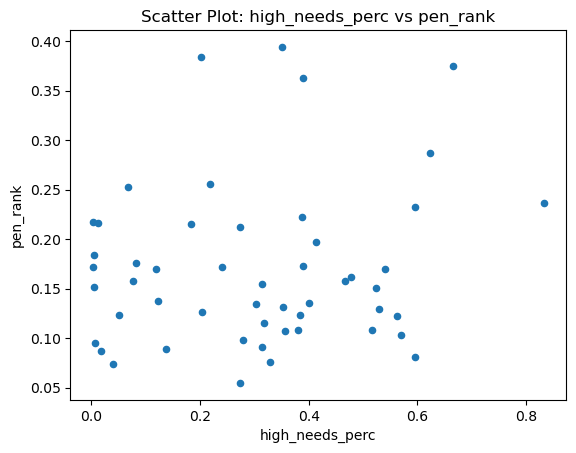

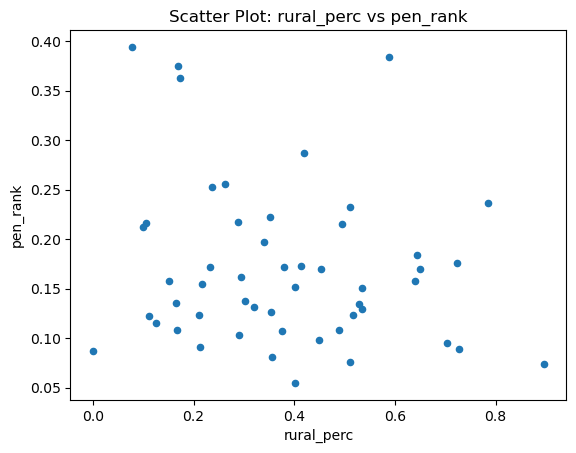

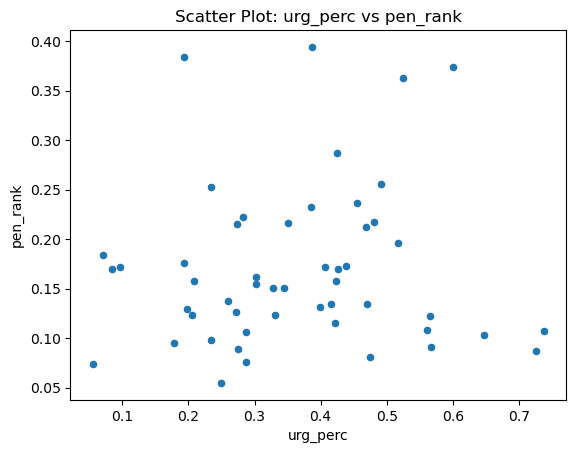

InvalidIndexError: (['high_needs_perc', 'rural_perc', 'urg_perc'], 'pen')

In [70]:


# Create a new DataFrame with the relevant columns
df_flat_view = df_demo[['high_needs_perc', 'rural_perc', 'urg_perc', 'demo_kpi_rank']].join(df_state[['pen', 'pen_rank']], lsuffix='_left', rsuffix='_right')

# List of KPIs to plot
kpi_list = ['high_needs_perc', 'rural_perc', 'urg_perc']

# Loop through each KPI and create a scatter plot
for kpi in kpi_list:
    df_flat_view.plot(kind='scatter', x=kpi, y='pen', title=f"Scatter Plot: {kpi} vs pen_rank")
    plt.xlabel(kpi)
    plt.ylabel('pen_rank')
    plt.show()  # Show the plot for each KPI

df_flat_view[kpi_list,'pen'].corr()